In [64]:
import numpy as np 
import pandas as pd 
from skimage.data import imread
from skimage import io
import matplotlib.pyplot as plt
import os
import pandas as pd 

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation,Dense, Flatten,BatchNormalization,Dropout, GlobalAveragePooling2D

from tensorflow.keras.layers import *
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model, Sequential, Model 
import itertools
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [65]:
train_image_dir = os.path.join('train_v2')
imgs = os.listdir('train_v2')
masks = pd.read_csv('train_ship_segmentations_v2.csv')
masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [66]:
masks2 = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
masks2['has_ship'] = masks2['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks2['has_ship_vec'] = masks2['ships'].map(lambda x: '1.0' if x>0 else '0.0')
masks = masks.drop_duplicates(subset=['ImageId'], keep='first')
masks.drop(['ships'], axis=1, inplace=True)
masks2 = pd.merge(masks2, masks, how='right', on=['ImageId'])
masks2

,ImageId,ships,has_ship,has_ship_vec,EncodedPixels,path
0,00003e153.jpg,0,0.0,0.0,NaN,train_v2\00003e153.jpg
1,0001124c7.jpg,0,0.0,0.0,NaN,train_v2\0001124c7.jpg
2,000155de5.jpg,1,1.0,1.0,264661 17 265429 33 266197 33 266965 33 267733...,train_v2\000155de5.jpg
3,000194a2d.jpg,5,1.0,1.0,360486 1 361252 4 362019 5 362785 8 363552 10 ...,train_v2\000194a2d.jpg
4,0001b1832.jpg,0,0.0,0.0,NaN,train_v2\0001b1832.jpg
5,00021ddc3.jpg,9,1.0,1.0,108287 1 109054 3 109821 4 110588 5 111356 5 1...,train_v2\00021ddc3.jpg
6,0002756f7.jpg,2,1.0,1.0,255784 2 256552 4 257319 7 258087 9 258854 12 ...,train_v2\0002756f7.jpg
7,0002d0f32.jpg,0,0.0,0.0,NaN,train_v2\0002d0f32.jpg
8,000303d4d.jpg,0,0.0,0.0,NaN,train_v2\000303d4d.jpg
9,00031f145.jpg,1,1.0,1.0,340363 1 341129 4 341896 6 342663 7 343429 10 ...,train_v2\00031f145.jpg


In [67]:
train_df, test_df = train_test_split(masks2, 
                 test_size = 0.3, 
                 stratify = masks2['ships'])
train_df=train_df.iloc[:2000,]
test_df=test_df.iloc[:1200,]
print(train_df.shape[0], 'training masks')
print(test_df.shape[0], 'test masks')
train_df['has_ship_vec'].shape

2000 training masks
1200 test masks


(2000,)

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                data_format = 'channels_last')
test_datagen =   ImageDataGenerator(
                   rescale=1./255,
                   shear_range = 0.01,
                   zoom_range = [0.9, 1.25],  
                   horizontal_flip = True,
                   fill_mode = 'reflect',
                   data_format = 'channels_last')

In [69]:

train_gen=train_datagen.flow_from_dataframe(train_df,None,
                                  x_col='path',
                                  y_col='has_ship_vec', 
                                  target_size = (256,256),
                                  color_mode = 'rgb',
                                  batch_size = 32,
                                class_mode='binary')
test_gen=test_datagen.flow_from_dataframe(test_df,None,
                                  x_col='path',
                                  y_col='has_ship_vec', 
                                  target_size = (256,256),
                                  color_mode = 'rgb',
                                  batch_size = 150,
                                  class_mode='binary')
train_gen.classes = np.stack(train_df['has_ship_vec'].values)
test_gen.classes=np.stack(test_df['has_ship_vec'].values)

Found 2000 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [70]:
Xtr,ytr = train_gen.next()
ytr.shape

(32,)

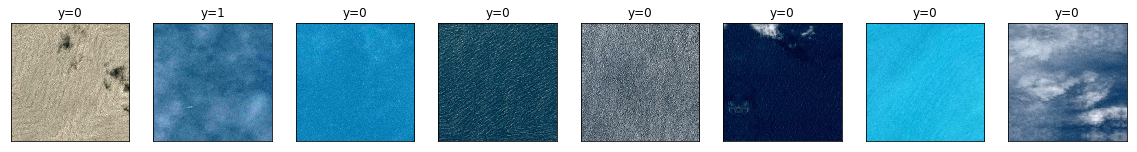

In [71]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
# Gray scale image
        plt.imshow(im, cmap='gray')
    else:
# Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)
# Remove axis ticks
        plt.xticks([])
        plt.yticks([])
nplot = 8
plt.figure(figsize=(20,10))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    disp_image(Xtr[i])
    plt.title('y=%d' % ytr[i])


In [72]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input 
nrow = 256
ncol = 256
input_shape = (nrow,ncol,3)
base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(256, 256, 3))

In [73]:
model = Sequential()
for layer in base_model.layers:
    model.add(layer)
for layer in base_model.layers:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       295168    
__________

In [75]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
steps_per_epoch =   train_gen.n 
validation_steps =  test_gen.n  
hist = model.fit_generator(
train_gen,
steps_per_epoch=steps_per_epoch,
epochs=5,
validation_data=test_gen,
validation_steps=validation_steps)

Epoch 1/5
63/63 [==============================] - 58s 915ms/step - loss: 0.7789 - acc: 0.7730 - val_loss: 0.3917 - val_acc: 0.8292
Epoch 2/5
63/63 [==============================] - 51s 809ms/step - loss: 0.4436 - acc: 0.8230 - val_loss: 0.3863 - val_acc: 0.8408
Epoch 3/5
63/63 [==============================] - 51s 803ms/step - loss: 0.4121 - acc: 0.8390 - val_loss: 0.3633 - val_acc: 0.8408
Epoch 4/5
63/63 [==============================] - 51s 802ms/step - loss: 0.3952 - acc: 0.8465 - val_loss: 0.3471 - val_acc: 0.8533
Epoch 5/5
63/63 [==============================] - 51s 802ms/step - loss: 0.3831 - acc: 0.8500 - val_loss: 0.3963 - val_acc: 0.8483
